# Quantum-CNN synergy: Redefining early predication of Pancreatic Cancer

Importing the necessary Libraries

In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Reading Data

This dataset contains information from 590 patients:

---

DataSet Link:-https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer

Healthy controls (183)
Patients with non-cancerous pancreatic conditions,like chronic pancreatitis

(208)

Patients with pancreatic cancer (199)

Our goal is to try to predict which patients have pancreatic cancer based on the features. Pancreatic cancer often shows no symptoms until it is too late for effective treatment, so an early test could be valuable.

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\surya\Downloads\Debernardi et al 2020 data.csv")

# Preprocessing
df['diagnosis'] = df['diagnosis'] == 3  # Convert to binary classification
df['sex'] = df['sex'].map({'M': 1, 'F': 0})

# Select relevant features
features = ['creatinine', 'plasma_CA19_9', 'age', 'sex', 'LYVE1', 'REG1B', 'TFF1']
target = 'diagnosis'


Data Preprocesing

In [3]:
df = df[features + [target]].copy()
# Drop rows with NaN values
df = df.dropna()


print(df['diagnosis'].value_counts())
print(df.describe())
df.head(20)


diagnosis
False    200
True     150
Name: count, dtype: int64
       creatinine  plasma_CA19_9         age         sex       LYVE1  \
count  350.000000     350.000000  350.000000  350.000000  350.000000   
mean     0.833650     654.002944   59.331429    0.488571    3.199363   
std      0.650878    2430.317642   12.988374    0.500585    3.544516   
min      0.056550       0.000000   26.000000    0.000000    0.000129   
25%      0.361920       8.000000   50.000000    0.000000    0.126749   
50%      0.655980      26.500000   61.000000    0.000000    1.886424   
75%      1.082933     294.000000   69.000000    1.000000    5.287402   
max      4.116840   31000.000000   87.000000    1.000000   23.890323   

             REG1B          TFF1  
count   350.000000    350.000000  
mean    117.811060    672.622797  
std     194.361832   1155.171378  
min       0.293000      0.005293  
25%      11.638096     40.053610  
50%      40.581909    327.161512  
75%     136.747135    778.645150  
max    12

,creatinine,plasma_CA19_9,age,sex,LYVE1,REG1B,TFF1,diagnosis
0,1.83222,11.700000,33,0,0.893219,52.948840,654.282174,False
2,0.78039,7.000000,51,1,0.145589,102.366000,461.141000,False
3,0.70122,8.000000,61,1,0.002805,60.579000,142.950000,False
4,0.21489,9.000000,62,1,0.000860,65.540000,41.088000,False
7,0.89349,11.000000,58,0,0.003574,3.730000,40.294000,False
9,0.61074,24.000000,56,0,0.278778,83.928000,19.185000,False
11,1.05183,23.000000,71,1,0.860337,243.082000,608.284000,False
13,1.91139,7.000000,53,1,1.516773,150.890000,590.686000,False
14,0.91611,12.000000,56,0,0.599645,93.811000,93.576000,False
15,0.50895,28.000000,60,0,0.002036,24.366000,19.698000,False


**Visualizing The Data**

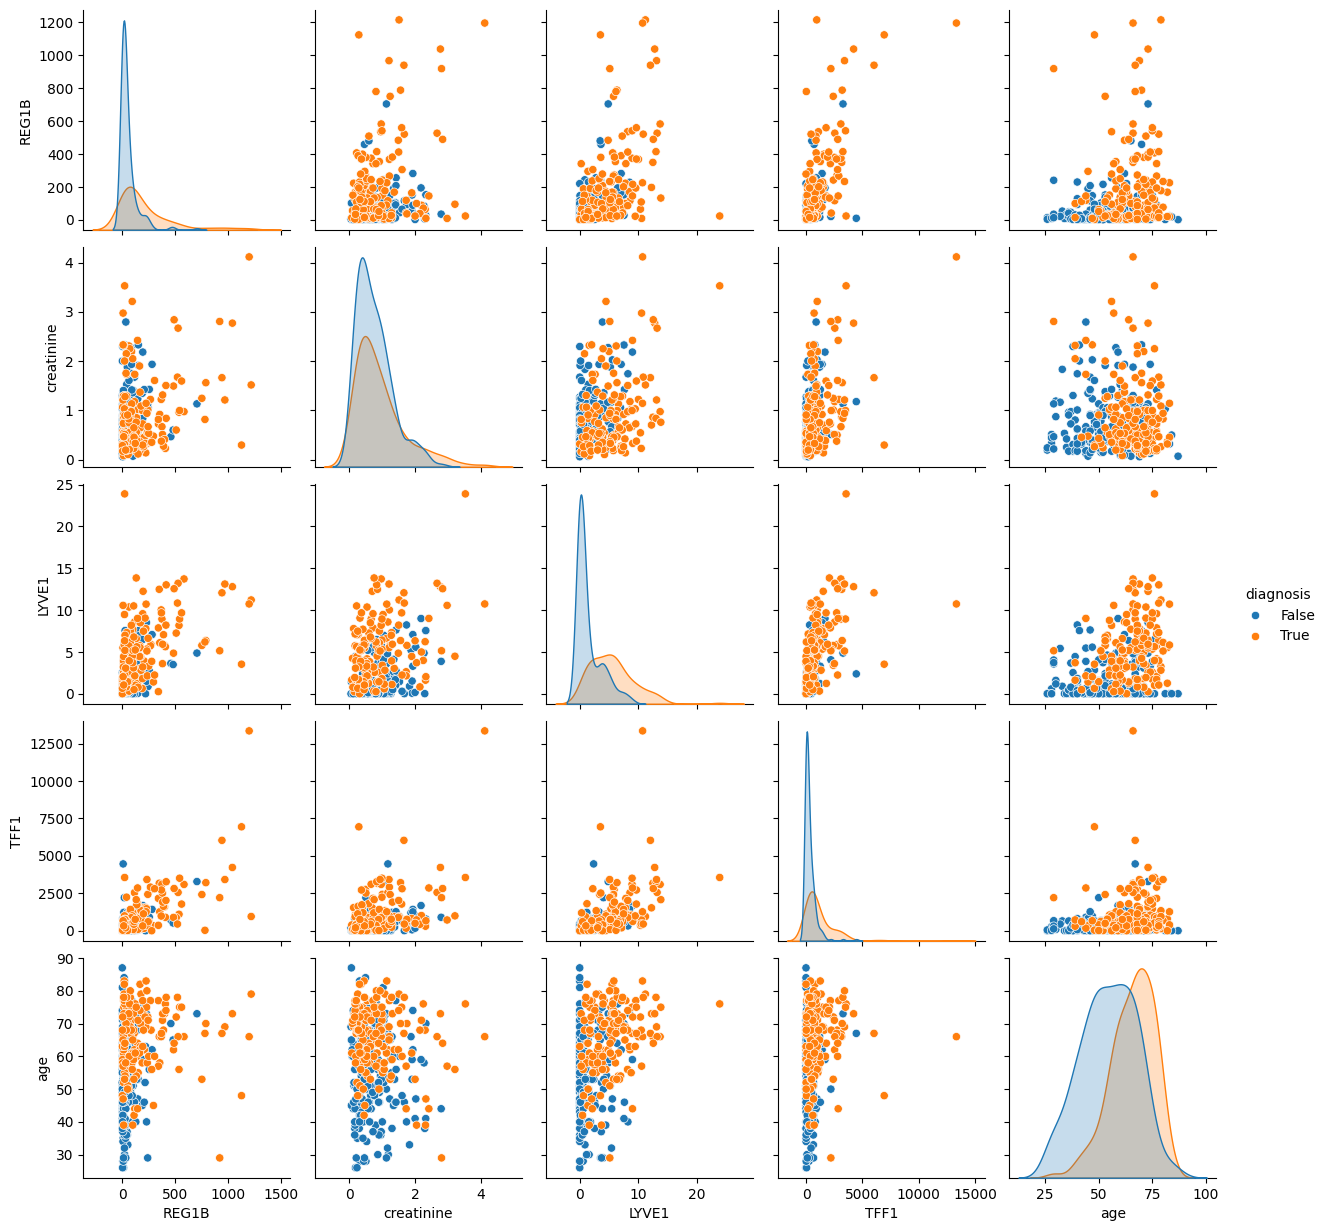

In [10]:
sns.pairplot(data = df, vars=['REG1B', 'creatinine', 'LYVE1', 'TFF1', 'age'], hue='diagnosis', diag_kind='kde')

It seems that there is a higher frequency of low values for REGB1 in negative diagnoses (FALSE) than in positive diagnoses (TRUE). Similarly, in the case of TFF1, the values appear to be higher in positive diagnoses, and small values seem to be more frequent in negative diagnoses. The distribution of LYVE1 values with respect to the diagnosis looks promising, as there is a higher probability of high values in the case of a positive diagnosis (TRUE), and a higher probability of low values in the case of negative diagnoses (FALSE) and the distributions are more separated.

<Axes: >

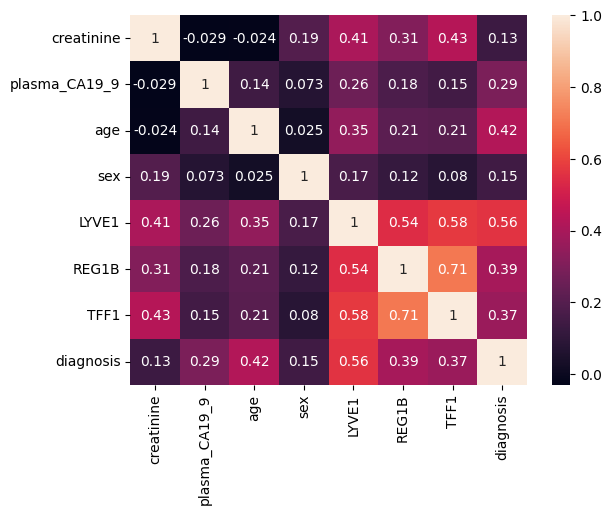

In [11]:
corr = df.dropna().corr()
sns.heatmap(corr, annot=True)

Spliting the data into training and testing data

In [12]:
# Train-test split
X = df[features].values
y = df[target].values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"X_train shape: {X_train.shape}")  # Expected: (batch_size, 7)
print(f"y_train shape: {y_train.shape}")  # Expected: (batch_size, 1)

X_train shape: torch.Size([280, 7])
y_train shape: torch.Size([280, 1])


Defining the *QCNN*

In [15]:
# Quantum device
n_qubits = len(features)  # One qubit per feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define Quantum Circuit
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))  # Measure qubit 0

# QNode
weight_shapes = {"weights": (3, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="best")

# Quantum Layer
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Define Hybrid Model
class HybridQNN(nn.Module):
    def __init__(self):  # Fix the typo here
        super().__init__()
        self.fc1 = nn.Linear(7, 7)  # Ensure input and output are both 7
        self.qlayer = qlayer
        self.fc2 = nn.Linear(1, 1)  # Ensure the output layer matches the quantum layer output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  # Apply non-linearity
        x = self.qlayer(x).reshape(-1, 1)  # Ensure quantum output is correctly shaped
        x = self.sigmoid(self.fc2(x))  # Ensure final output is between 0 and 1
        return x

Training The model

In [16]:
# Model, Loss, and Optimizer
model = HybridQNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)

   # print(f"y_pred min: {y_pred.min()}, max: {y_pred.max()}")
    #print(f"y_train min: {y_train.min()}, max: {y_train.max()}")

    loss = criterion(y_pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.8310
Epoch 10: Loss = 0.7657
Epoch 20: Loss = 0.7124
Epoch 30: Loss = 0.6598
Epoch 40: Loss = 0.6017
Epoch 50: Loss = 0.5576
Epoch 60: Loss = 0.5278
Epoch 70: Loss = 0.5024
Epoch 80: Loss = 0.4835
Epoch 90: Loss = 0.4702


Tesing The QCNN model

In [17]:
# Evaluation
y_pred_test = model(X_test).detach().numpy()
y_pred_test = (y_pred_test > 0.5).astype(int)

accuracy = np.mean(y_pred_test == y_test.numpy())
print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8429


Saving The Model

In [18]:
torch.save(model.state_dict(), "pancreas_detection.pth")

Saving the operations that are made on the input data

In [19]:
import joblib

# Save the fitted scaler after training
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully!")


Scaler saved successfully!


Identifying Importance of Each Feature

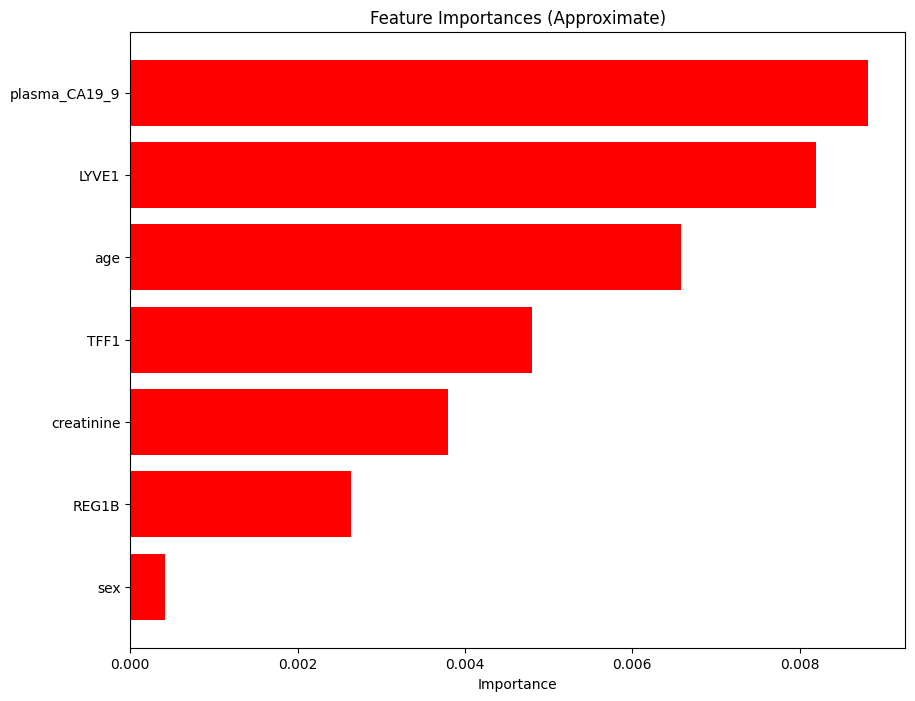

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Make sure model and X_test are tensors
feature_names = features  # Replace with actual names

def compute_feature_importance(model, X_test, perturbation=0.1):
    model.eval()
    base_predictions = model(X_test).detach().numpy().flatten()  # Remove `.values`
    importances = []

    for i in range(X_test.shape[1]):  # Iterate over features
        X_perturbed = X_test.clone().detach()  # Clone to avoid modifying the original tensor
        X_perturbed[:, i] += perturbation  # Slightly perturb feature i
        perturbed_predictions = model(X_perturbed).detach().numpy().flatten()

        # Compute importance as mean absolute difference in predictions
        importance = np.mean(np.abs(perturbed_predictions - base_predictions))
        importances.append(importance)

    return np.array(importances)

# Compute importance scores
importances = compute_feature_importance(model, X_test)

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Approximate)")
plt.barh(range(len(importances)), importances[indices], color="red", align="center")
plt.yticks(range(len(importances)), np.array(feature_names)[indices])  # Use actual feature names
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(selected_y_test, selected_y_pred)

print("\n📊 Confusion Matrix:")
print(conf_matrix)


📊 Confusion Matrix:
[[6 2]
 [1 1]]


In [6]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib
import pennylane as qml

# ✅ Load the trained model
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 7)  

        # ✅ Define the quantum circuit with correct parameter names
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(7))  # Encode input into qubits
            qml.BasicEntanglerLayers(weights, wires=range(7))  # Apply trainable layers
            return qml.expval(qml.PauliZ(0))  # Measure output from qubit 0

        # ✅ Define device and QNode properly
        dev = qml.device("default.qubit", wires=7)
        qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="best")

        # ✅ Correctly initialize the quantum layer
        weight_shapes = {"weights": (3, 7)}  # Ensure correct weight shape
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

        self.fc2 = nn.Linear(1, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  
        x = self.qlayer(x).reshape(-1, 1)  
        x = self.sigmoid(self.fc2(x))  
        return x


# ✅ Load model
model = HybridQNN()
model.load_state_dict(torch.load("pancreas_detection.pth"))
model.eval()  # Set to evaluation mode

# ✅ Load the scaler
scaler = joblib.load("scaler.pkl")

# ✅ Load and preprocess the dataset
df = pd.read_csv(r"C:\Users\surya\Downloads\Debernardi et al 2020 data.csv")
df['diagnosis'] = df['diagnosis'] == 3  
df['sex'] = df['sex'].map({'M': 1, 'F': 0})

features = ['creatinine', 'plasma_CA19_9', 'age', 'sex', 'LYVE1', 'REG1B', 'TFF1']
target = 'diagnosis'
df = df[features + [target]].dropna()

X_test = df[features].values
y_test = df[target].values.astype(np.float32)

# ✅ Scale the test data
X_test = scaler.transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ✅ Select 10 random test cases
num_test_cases = 10
indices = np.random.choice(len(X_test), num_test_cases, replace=False)

# ✅ Run predictions
print("\n🔹 *10 Test Case Predictions* 🔹\n")
for i in indices:
    input_features = X_test[i].unsqueeze(0)  
    true_label = int(y_test[i].item())  
    
    with torch.no_grad():
        raw_prediction = model(input_features).item()  
    
    predicted_label = int(raw_prediction > 0.5)

    print(f"Test Case {i+1}:")
    print(f"  🔹 Features: {X_test[i].numpy()}")
    print(f"  ✅ True Label: {true_label}")
    print(f"  🔮 Raw Prediction: {raw_prediction:.4f}")
    print(f"  🔥 Predicted Label: {predicted_label} ({'Cancer Detected' if predicted_label == 1 else 'No Cancer'})")
    print("-" * 50)

# ✅ Compute accuracy
selected_y_test = y_test[indices].numpy()
selected_y_pred = model(X_test[indices]).detach().numpy()
selected_y_pred = (selected_y_pred > 0.5).astype(int)

accuracy_10_cases = np.mean(selected_y_pred == selected_y_test)
print(f"\n🎯 Accuracy on 10 Test Cases: {accuracy_10_cases:.4f}")


🔹 *10 Test Case Predictions* 🔹

Test Case 109:
  🔹 Features: [-0.65969145 -0.23218936 -0.4783564   1.0071685  -0.21061191  0.16114332
 -0.51056284]
  ✅ True Label: 0
  🔮 Raw Prediction: 0.2611
  🔥 Predicted Label: 0 (No Cancer)
--------------------------------------------------
Test Case 249:
  🔹 Features: [-0.7308818  -0.25013134  1.7642844  -0.9928825   0.69185555  0.33352104
  0.09928871]
  ✅ True Label: 1
  🔮 Raw Prediction: 0.8003
  🔥 Predicted Label: 1 (Cancer Detected)
--------------------------------------------------
Test Case 266:
  🔹 Features: [-1.0020833  -0.1825417   1.3002898   1.0071685  -0.6117144   0.08246596
  0.21495594]
  ✅ True Label: 1
  🔮 Raw Prediction: 0.6944
  🔥 Predicted Label: 1 (Cancer Detected)
--------------------------------------------------
Test Case 73:
  🔹 Features: [ 0.30307364 -0.25639108 -0.55568886  1.0071685   0.43665695 -0.29710215
 -0.4546309 ]
  ✅ True Label: 0
  🔮 Raw Prediction: 0.2687
  🔥 Predicted Label: 0 (No Cancer)
-------------------

In [9]:
# ✅ Predict on the full test set
with torch.no_grad():
    full_predictions = model(X_test)
    predicted_labels = (full_predictions > 0.5).float()
    correct = (predicted_labels == y_test).sum().item()
    total = y_test.size(0)
    full_accuracy = correct / total

print(f"\n📊 Overall Accuracy on Full Test Set: {full_accuracy:.4f}")


📊 Overall Accuracy on Full Test Set: 0.8200


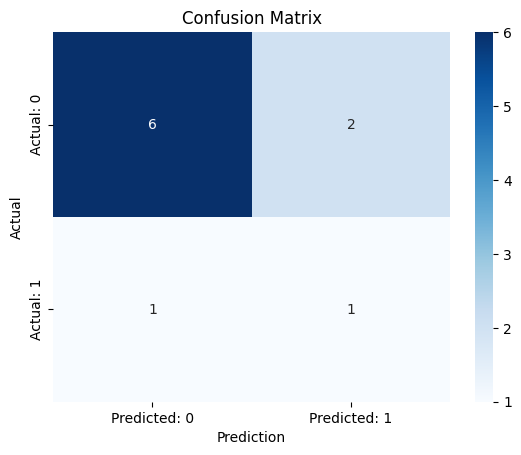

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted: 0", "Predicted: 1"],
            yticklabels=["Actual: 0", "Actual: 1"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()


In [11]:
from sklearn.metrics import classification_report

print(classification_report(selected_y_test, selected_y_pred, digits=4))


              precision    recall  f1-score   support

         0.0     0.8571    0.7500    0.8000         8
         1.0     0.3333    0.5000    0.4000         2

    accuracy                         0.7000        10
   macro avg     0.5952    0.6250    0.6000        10
weighted avg     0.7524    0.7000    0.7200        10

